# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

<span style="color:blue">There are three columns, an index column, a time column (with time given by calendar months) and a sales column.</span>

Let's check out the data types of our columns.

In [5]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

<span style="color:blue">The index and sales columns are ints, while the time column is an object</span>

Check whether there are any null values. 

In [6]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [7]:
cigData.describe()

,Unnamed: 0,#CigSales
count,144.000000,1.440000e+02
mean,71.500000,1.000280e+06
std,41.713307,1.199663e+02
min,0.000000,1.000104e+06
25%,35.750000,1.000180e+06
50%,71.500000,1.000266e+06
75%,107.250000,1.000360e+06
max,143.000000,1.000622e+06


<span style="color:blue">There are no null entries.</span>

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


<span style="color:blue">The column has been removed.</span>

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [10]:
cigData.rename(columns={'Time': 'Month'}, inplace=True)

In [11]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Call a head() to check this has worked. 

In [12]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [13]:
cigData.Month = pd.to_datetime(cigData.Month)

In [14]:
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [15]:
y = cigData['#CigSales']
y.index = cigData['Month']

<span style="color:blue">Additionally, the series is given a datetime index for simplicity.</span>

Check the type of our new variable. 

In [16]:
type(y)

pandas.core.series.Series

In [17]:
y.dtype

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [18]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

<span style="color:blue">The scaling of the data presented problems. A web search discovered that this data was actually a transformed version of well-known `airline passenger` data. A constant of 1,000,000 was added to each entry. Unfortunately, this complicated much of the later analysis (in particular, on taking logarithms, the series becomes nearly constant). I elected to subtract 1,000,000 from each entry.</span>

In [19]:
y = y.sub(1000000)

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

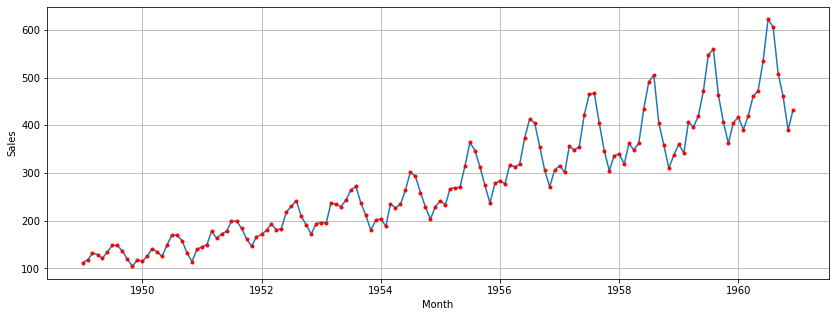

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 5))
ax.grid()
plt.plot(y, '-');
plt.plot(y, '.r');
plt.xlabel('Month');
plt.ylabel('Sales');

<span style="color:blue">We find a general upward trend with an obvious seasonal cycle with period of one year.</span>

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

<span style="color:blue">The seasonal trend increases with time, so the multiplicative model should be more appropriate.</span>

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

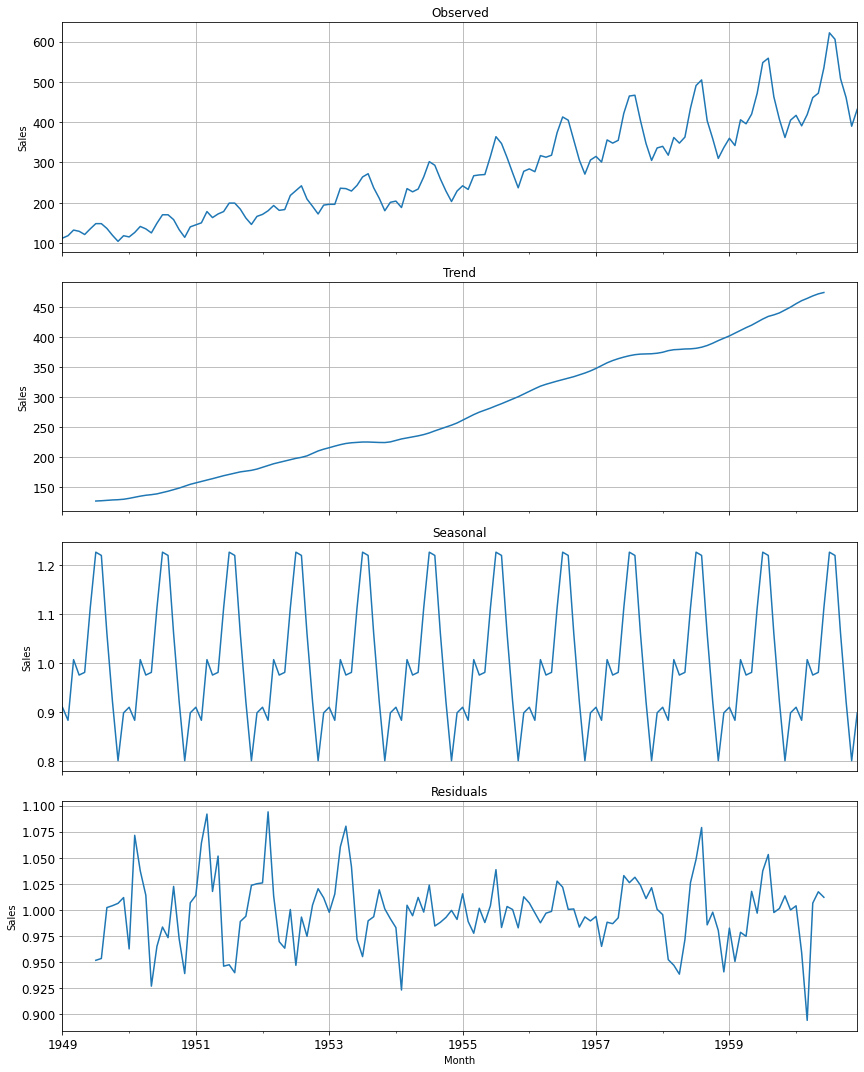

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y, model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 15))
components = (decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid)
titles = ('Observed', 'Trend', 'Seasonal', 'Residuals')
for (decomp, ax, title) in zip(components, axes, titles):
    decomp.plot(ax=ax, fontsize=12, xlabel='Month', ylabel='Sales', title=title);
    ax.grid();

plt.tight_layout();

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [22]:
from statsmodels.tsa.stattools import kpss

# kpss gives a warning if the p-value is too large or too small, as the p-value is calculated using interpolation.
# This doesn't matter for the current project, so ignore this warning.
import warnings
warnings.filterwarnings("ignore", message="the test statistic")

kpss_stat, p_value, lags, crit = kpss(y, regression='c', nlags="auto")
print(f"The test-statistic is {kpss_stat:0.3f}, giving a p-value of {p_value:0.3f}")

The test-statistic is 1.651, giving a p-value of 0.010


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

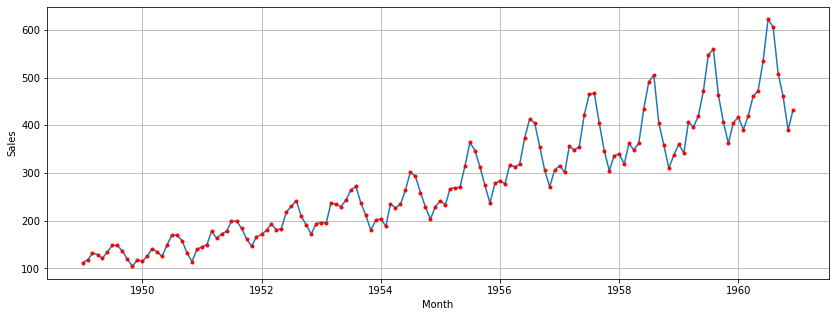

In [23]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.grid()
plt.plot(y, '-');
plt.plot(y, '.r');
plt.xlabel('Month');
plt.ylabel('Sales');

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [24]:
import numpy as np
log_y = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

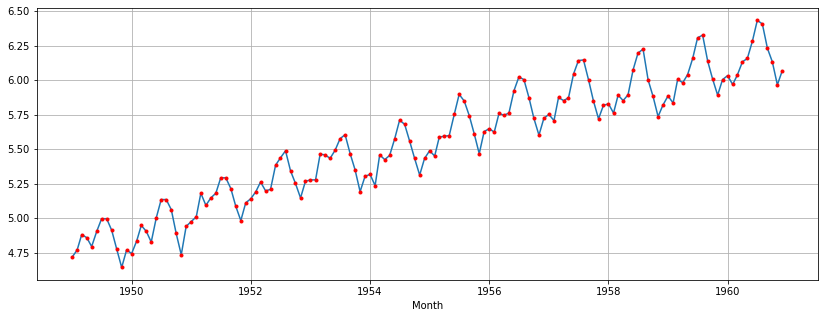

In [25]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.grid()
plt.plot(log_y, '-');
plt.plot(log_y, '.r');
plt.xlabel('Month');

In [26]:
kpss_stat, p_value, lags, crit = kpss(log_y, regression='c', nlags="auto")
print(f"The test-statistic is {kpss_stat:0.3f}, giving a p-value of {p_value:0.3f}")

The test-statistic is 1.669, giving a p-value of 0.010


We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [27]:
diff_log_y = log_y.diff()

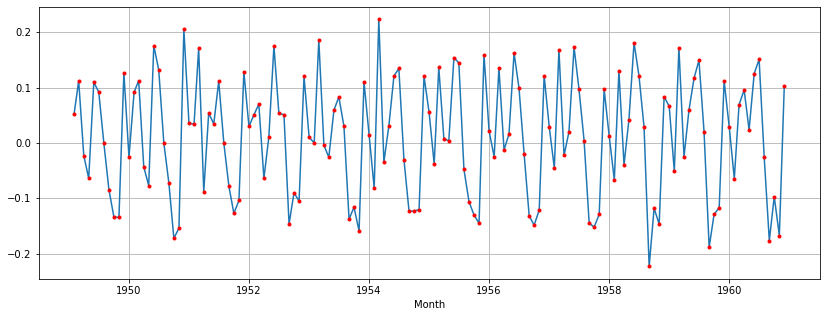

In [28]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.grid()
plt.plot(diff_log_y, '-');
plt.plot(diff_log_y, '.r');
plt.xlabel('Month');

In [29]:
kpss_stat, p_value, lags, crit = kpss(diff_log_y[1:], regression='c', nlags="auto")
print(f"The test-statistic is {kpss_stat:0.3f}, giving a p-value of {p_value:0.3f}")

The test-statistic is 0.038, giving a p-value of 0.100


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [30]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

<span style="color:blue">The ARIMA model included here originally has been deprecated. We use the replacement instead.</span>

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [31]:
def ts_test_train_split(y, test_size):
    '''
    Splits the time-series y into train and test sections. The variable test_size should be a float between 0 and 1. The \
    function splits the time-series in such a way as to provide the tail-end of the series as a test set, of approximately \
    a proportion of test_size of the full series. The remaining part of the series is returned as the training set. 
    '''
    split_index = int((1 - test_size) * len(y))
    y_train = y[:split_index]
    y_test = y[split_index:]
    # Setting the frequency of the test/train components is a simple form of suppressing ARIMA warnings related to use of \
    # inferred frequencies.
    y_train.index.freq = y.index.inferred_freq
    y_test.index.freq = y.index.inferred_freq
    return y_train, y_test

In [32]:
def ts_evaluate_model(y, order, seasonal_order, test_size=0.2, metric=mean_squared_error):
    '''
    Trains a seasonal ARIMA model on the time series y and evaluates it using the metric. The metric must be a function taking \
    two time-series as arguments.
    '''
    y_train, y_test = ts_test_train_split(y, test_size)
    # fit model to training data
    model = ARIMA(y_train, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    # get predictions and compare against the actual series.
    y_pred = results.get_forecast(len(y_test)).predicted_mean
    score = metric(y_test, y_pred)
    return score

<span style="color:blue">There were serious difficulties with the assignment at this point. In particular, the ARIMA model requested has no seasonal component, but the data definitely has seasonality. Consequently, we will fit using a seasonal component as well.</span>

In [33]:
# There's a fair amount of commonality between this and ts_evaluate_model. An obvious path forward would be to re-factor this \
# code.
def ts_plot_model(y, order, seasonal_order, test_size=0.2):
    '''
    Plots the prediction against the observed series.
    '''
    y_train, y_test = ts_test_train_split(y, test_size)
    # fit model to training data
    model = ARIMA(y_train, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    y_pred = results.get_forecast(len(y_test)).predicted_mean
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.grid()
    plt.plot(y, '-', label='Observed');
    plt.plot(y_pred, '-r', label='Predicted')
    plt.xlabel('Month');
    plt.legend()
    return plt

<span style="color:blue">As an example, the discussion below suggests modeling the time series using a non-seasonal ARIMA with order (2,1,1). This is obviously incorrect as can be immediately observed by plotting.</span>

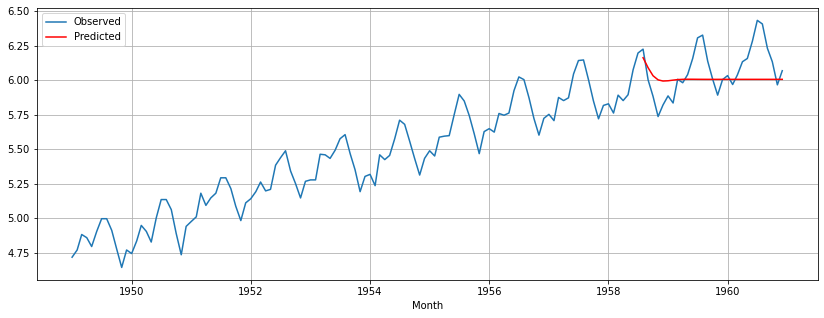

In [34]:
ts_plot_model(log_y, (2,1,1), None);

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [35]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_arima(y, p_list, d_list, q_list, P_list, D_list, Q_list, m=12, test_size=0.2, metric=mean_squared_error):
    '''
    Finds the best-fitting ARIMA using the given metric.
    '''
    
    min_score = None
    min_order = None
    min_seasonal_order = None
    
    # This is extremely ugly, but a simple implementation.
    for p in p_list:
        for d in d_list:
            for q in q_list:
                for P in P_list:
                    for D in D_list:
                        for Q in Q_list:
                            try:
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, m)
                                score = ts_evaluate_model(y, order, seasonal_order, test_size, metric)
                    
                                print(f"Score for (p, d, q) = {order}, (P, D, Q, m) = {seasonal_order}: {score}")
                                if (min_score is None) or (score < min_score):
                                    print(f"New best score!")
                                    min_score = score
                                    min_order = order
                                    min_seasonal_order = seasonal_order
                            except:
                                pass
                
    return min_order, min_seasonal_order

In [36]:
common_list = range(0,3)
p_list, d_list, q_list, P_list, D_list, Q_list = common_list, common_list, common_list, common_list, common_list, common_list

In [37]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
best_order, best_seasonal_order = evaluate_arima(log_y, p_list, d_list, q_list, P_list, D_list, Q_list)

Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 0, 0, 12): 0.4705721304864935
New best score!
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 0, 1, 12): 0.37555094083339685
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 0, 2, 12): 0.2421673701858969
New best score!
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.031163168486885093
New best score!
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.025592962212720317
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.02749361868888218
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.013720848849992693
New best score!
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.009135124172416312
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.007377496601993368
New best score!
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.045617777271531906


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.042678732898571665


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.05019389168470906
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.011861703606461086
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.007692394824878302


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.006625144350520449
New best score!
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.009058983065922647
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.010253383259241246


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.007075926704583368
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.038391240222296695
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.00620146002538661
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.008357304143556605
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.0065763898496445095
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.009081997210435198
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.008039073348661772
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.009431994299092245
Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.011866972085388873


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.006879024122302685
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.4533764468456357


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.3600495866009404


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.24454611362712148
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.030132230167839412
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.025668578069804958


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.02505005477209749
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.013000076984770436
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.00829715692557669


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.008573270563533157
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.0483975532188178


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.047728299231594315


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.04934402322228915
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.014570366703639374


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.006349653938841317
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.006654960326912937
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.008409170779318804
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.009788775716388195


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.00777389832489
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.04407588245876601


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.004557252348348582
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.0035905976451858614
New best score!
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.006292625398373114


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.008178092186192695


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.006860096041712064
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.009249936828013599
Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.011939618446184868


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.0075068268306308005
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.44749552340335497


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.35636756882049286


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.23170110315121004
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.030046512456597903
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.026405496433001857


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.023535936691455567
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.011745638831763239
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.006888598346228852


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.010660388724097632
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.04491952724982453


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.04625179350971422


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.04740856655160286
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.01955972563865501


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.00436826414953307


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.009340605475836516
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.007458946625765283
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.008477658840604075


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.010760838921313395
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.04580855775977143


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.002451514564160782
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.012446385728680606
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.007332186124049443


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.005977286277724701


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.004930152030244748
Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.007717754971493978


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.010019949086600179


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 0, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.011351024533132638
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 0, 0, 12): 0.04532078978801865
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 0, 1, 12): 0.02407127336810913


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 0, 2, 12): 0.018112067884967487
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.006568844645639373


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.0013232993257573324
New best score!
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.001310231726518932
New best score!
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.0500775606736254
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.009013874663845992


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.0014061964249463424
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.004093303802480765
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.001632325704883964
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.0016349220599084276
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.0025397583363190295
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.0013136377531684105


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.0013680341352714466
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.02656466898090678
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.0055745409924345705


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.0015238198752237013
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.002252595037973892
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.0015851915959734111
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.0015988625519007442
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.0013116341849848299
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.0012157501236164533
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.0012304192584395909
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.023668644297758848
Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.003989646661296507


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.005999121528247745
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.05084611547388001
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.025403195372330562


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.017161417295526303
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.00954094443049876
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.0011995440418041533
New best score!


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.0012439013284982602
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.06335553814322678


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.013136633222053508
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.0023586135793336512
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.006404868542893491
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.001308591030495231
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.0013082006298185756
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.0038035309492390488
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.001235451796118174


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.0012343077718329654


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.04568775992362769
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.008197151291957836


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.002167615477482576
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.0032619615681618867
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.0013057129092395408
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.001328914745449033
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.0017321676994823782


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.0012004332841626087
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.001221966179933127
Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.03236768856866256


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.0055769404063137715


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.0054398567675710005
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.03506063641190179
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.02200328733504829


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.015835987946977038
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.009786738215564413
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.0012288062480119487


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.0012766064562708495
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.06383835601930933
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.013182221424924971


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.002072726834570057
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.007070311508915899


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.0013231570062164312


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0013464332034461906
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.0038585722965876136
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.0012702121756845053


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.0012615796618091466
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.04609140739211275


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.008316473323485011


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.002214868115326557
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.0034975022102984093
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.0013293419502968364


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.0013903603262653374
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.0017775125292385538
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.0012231344654433569


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.001247877082452988
Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.03274280630510753


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.005544563499907555


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 1, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.002579782300518218
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 0, 0, 12): 4.658292589730426
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 0, 1, 12): 2.801396682117189
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 0, 2, 12): 2.7615542116570526
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.2979698559417509


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.09276531053602927


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.10746291005090594
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.5284018159322673


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.1755542186675619
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.013292126482577476
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.8950139890774378
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.15525520201605708


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.1697777921010435
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.228564518773832


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.1046024590912878


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.08515686178586175
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 2, 0, 12): 2.0305636634721758
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.17360897009010967


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.014271557826625775
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.49596669360054557
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.16779060178835817


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.14019094365711052
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.011740447376496847
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.045754995362195634


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.048285914596286415
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.6005787868661291
Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.002177512524496618


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.0103931713759202
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.12561502417294299
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.0414843715231142
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.038045589947479364
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.005716761071108063
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.0012451938973220315


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.0012777129735955628
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.09041882809866164
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.06609651194535866


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.029259873286839357


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.0031229009246140416
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.0017375005564082863


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.0016874451356944638
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.0031059251131053916
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.0012503519383980127


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.0012566048302704925
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.05716731046757192
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.04682084345275869


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.031976251811477986
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.0018925390202271086
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.0019204428125766274


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.0017249185696863998
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.0019309448590473363
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.0012826283655179873


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.0012770548294397824
Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.05653657479264865


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.04239672332201211


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.03044955892505033
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.13919064910679213


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.059297108266062104


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.03344862919435483
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.011505967436218874
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.0017799582290362796


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.0023210998203448082
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.11746522760422112
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.08695132663055945


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.05125779937813005


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.0050434102604427
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.0014274175286034237


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0014527758704768337
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.00579848660244267


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.003220506097702415
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.0022944178354030943
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.0895557790077555
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.06674543230119712


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.038254438149793506


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.0032973458752054447
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.0013521561419399227


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.0013129221662744517
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.0033478891671342836


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.003578480777438363


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.0019821976218683114
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.0990467683526807
Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.06259375078447178


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (0, 2, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.0727579339659823
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 0, 0, 12): 0.06171552049162201
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 0, 1, 12): 0.06430775281037296


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 0, 2, 12): 0.051625072794827545
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.016640455234256103
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.0026030853575879902


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.0027183151932774177
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.010230727465755813
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.0035942405481269113


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.008740380839004316
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.024050081659460838


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.0065290722566786405


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.007046846717487132
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.008814040118028011
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.002825842482436333


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.0015190442120779418
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.005104216542126487
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.005057471714456413


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.009148494743211123
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.012821868487341683


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.029607758114438866


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.01002358004176488
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.004672008086744697
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.0035493536733169316


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.0009170877573067672
New best score!
Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.0035436144446171565


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.007015272935393088


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.009473014579561087
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.111736405257072


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.08561626851432272


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.04747029790219425
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.014083612895526681
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.0022436831635243635


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.002346632724046318
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.011330525124576048
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.0017162215727124675


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.003739803686836585
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.01859733199070216


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.004622692009178571


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.0123242733901606
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.0065773353128845006
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.0024454134799174604


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.001017451608327876


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.007732049058955824
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.0013948729688161893


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.00272707455317387


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.00906614229603622
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.04401451150147737


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.004500345492890821
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.003511141752688427
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.0022115290709811245


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.0056152270184942985
Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.00293400866416892


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.0018112852800371458


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.0023663519208126363
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.05857296468192992


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.07472084849085682


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.03824830918629679
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.014603916565644411


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.002202825206013149


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.00240080464304763
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.01012804318793924


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.0017606302320872004


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.0053167122668540245
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.018566647751066378


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.004552812262370025


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0053804139323114985
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.006516171577710628


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.005020644358364239
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.0008178663229241269
New best score!
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.007371502154906735
Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.0012409260657235785


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.003733496590323241


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.009928311790938331


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.047280168098057546


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.00539721842941828


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.0055368959167815925


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.002053127228426606


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.0008378080513334863


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.002819972693639959


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.0024631107058697738


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 0, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.0030484594123960833
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 0, 0, 12): 0.05265835064365156
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 0, 1, 12): 0.0255872705902563


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 0, 2, 12): 0.017321119079869118
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.008215438302733183
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.0011585206073396143


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.001151239715803589
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.05879271670435109
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.011650165654444235


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.002140261377849154
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.005414747206039944
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.0013407570255774856


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.0013236318672418135
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.003091767175207051
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.0011529338600257415


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.001155623634603847
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.03762589050530464


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.007183519847945128


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.0020061824136847132
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.0027171535693466062
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.0013198325200834509
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.0013072480920810858
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.0015432083028021231
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.0011327596304468238


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.0011460933378694559
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.029541298345413938


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.005066538761408545
Score for (p, d, q) = (1, 1, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.007006266360111498
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.0482970600800163
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.024075755856768733


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.018051401764211668
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.008207936393108243
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.0011588609209412148


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.0012874419424035773
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.05637161609198501
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.011393185495166448


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.0019957047600216394
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.004908039348930074


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.0014585512178889952


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.001290957983697117
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.003909334182073346


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.00127798732815065
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.001155838851821116
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.0462326750923992


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.008180598618282128
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.002013284980169477


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.003744042016016157
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.0014152896642279744


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.0013411054270702119
Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.0017989809428397127


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.001219151336567262


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.0011716466043156615


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.0329399466912185


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.005470089992918826


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.007056452589033165
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.033065928833673784
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.02765282754130508


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.01847195763144259
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.00897361620142861
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.0011784351774186909


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.001213299051605822
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.06037237839928743
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.012435853923244707


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.002474996051359925


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.0037473970800945724


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.002987711431501886


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0016192640434115886


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.0036236164899964025
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.0012053680607775105


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.001202737797158318


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.04338680685596941
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.008145827201904616


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.0022843341564309683


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.0036103172076226786


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.0021776289358534113


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.0013409909419381041


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.0017159255832186393
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.0011750009905959176


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.0012043060452367523
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.03227353793208212
Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.005502237454515065


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 1, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.003342935069099728
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 0, 0, 12): 5.78871767023972
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 0, 1, 12): 4.223980761874356
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 0, 2, 12): 3.440257787639543
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.14382683955182965


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.1836507796148422
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.2043020884429468
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.09803036391581398
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.04650153470107397


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.024590055495121842
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.48270728503810867
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.23953821926105312


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.27791492186346073
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.14443864395557543
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.2062067838691205


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.19468486747179575
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.6004733897719352
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.05957198760721055


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.03361383218915618


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.28219578741462314
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.26633822045045735


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.25743078226341
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.06700018243020656
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.19708427982763715


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.2024553840607638
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.15434099864808873
Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.011185576185296926


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.05241337535735473
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.14442085999958573
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.04388688207102331


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.03723234688977159


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.00825889895145211
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.0014055050348497527


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.0016281941281325518
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.11227803246073904
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.07266348735891591


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.033061055152897305


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.004311925259211142


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.0013997207602941366
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.0013168667280352995
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.004891554504105317
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.0015243051906552326


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.0014982942527005621
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.12054431349775806


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.051555749267563095


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.03305578117778972


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.0023554534938660648


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.0012965105568993648


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.001426031299430524
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.0023202782744750215


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.0018868735159674943


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.004744308921801848
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.06861841461914725


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.039084875749606444
Score for (p, d, q) = (1, 2, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.048077969437887266
Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.13382649893419163
Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.05529665309052449


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.03955997264569991
Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.008023668368057353


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.0015010806818251128


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.0029895597756165308
Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.10609065467285228


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.0711594682995561


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.054958344680980084
Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.0038990149700815243


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.001895151309767244


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0022115267453633397


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.008026837729975894


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.0035399922780170404


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.001973952299177368
Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.0705700269977572


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.10060267458769691


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.032637556498385525


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.002391779424943408


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.0014162736650622286


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.0013992929828974309


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.004765625502540479
Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.003045154831033408


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.003835923835629681


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.06448911024062713


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.047374134508448025


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (1, 2, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.08792633819056443
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 0, 0, 12): 0.10243620743991894


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 0, 1, 12): 0.08579212626377714
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 0, 2, 12): 0.04746036459009681
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.014559064495631243
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.002115590017496609


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.002287223386207921
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.011093391612063803
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.001950016729610258


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.006397555642198836
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.018642495818348426


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.004742754140812901


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.00763592516211084
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.006640639816243906


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.0032658804893460356


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.0008614600531629525
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.005698002710994012
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.001514581429677369


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.00645718877421509
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.009097470900726084


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.03503724733633587
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.004689733705108131


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.0035472113789732644


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.002712538561968242


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.0012085256751886047
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.002604630735156846


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.0037987713560285893
Score for (p, d, q) = (2, 0, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.002364069726057619
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.08042477167204265


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.05027056247027827


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.046619657021618605
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.01502894572168725
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.002263780022024996


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.0033946525657764025
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.010496806776233141
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.0022777633243639818


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.006187849338472601
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.019777760052405148


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving

Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.012162955869839297


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.00964013564760018


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.007690374959871832


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.0041410362716542935


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.0023205249385137515
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.005052580321234491


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.002841870961444286


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.006733959229762321


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.01047761706504524


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.01933240310549589


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.009264366341785808


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.004744473905554344


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.003966878150770469


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.0028716994391721853
Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.00264597579330637


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.004894305703971724


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 0, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.006220923430909657
Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.0823184274287481


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.07212846342288262


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.05321530842013806


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.01418487800070436
Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.0024720557584054993


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.002566309391885869
Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.010228493928618946
Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.0022385270568258367


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.00438520851151471


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.01936703324923142


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal au

Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.0035203184987539814


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0018354733085992677


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.006166565440524948


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.0016501920934035297
Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.002025162109305152


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.0059657174196826954


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.0012114095381891884


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.0009741328451910947


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.010097335173664795


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal au

Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.015513279077003773


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.004533259427516166


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.0035924859704279167


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.0013344883807892066


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.003676883305475449


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.002726465670782069


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.0017251599885155715


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 0, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.0013810367744254756
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 0, 0, 12): 0.03893154719588036
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 0, 1, 12): 0.022429127436029896


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 0, 2, 12): 0.017354401486104662
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.008242343079784331
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.0011582014334013658


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.0011549000337003294
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.05835339967219686
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.01180104495932523


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.0023711501854335078
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.005344821177932606


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.001408740772949754
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.0013133313042022505
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.0031673735774298026
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.0011547280598652942


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.0011565704377980615
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.03864547272156629


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.007522064194375849


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.001988068959904512
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.002761233318360142
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.0013180112226974202
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.0013060229902825582
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.0015675661958304411
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.0011356555280908826


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.0011494504016324439
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.030078495509699512
Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.005509511900564255


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.009195234181497671
Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.0329252599563805
Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.028263454832037162


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.0186931143445837


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.0016656236450600928


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.002403375109338148


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.0011375797562494653
Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.02009032212290073


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.010933662059258593


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.001791434877914226


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.00388734504180302


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.0035279416443625574


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.002016117868393498
Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.0034393950900628158


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.0011411799252231455


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.005176939546715193
Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.04439701642221771


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.007722193863239852


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.0010273571503307418


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.0014809397061484515


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.0021591676263937477


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.0013011782769006297


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.0016025518796465423


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal m

Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.0011478820475358516


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.0011520270676905991
Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.03239098594119765


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.005512278500196413


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.006740302449215202
Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.032952820892135457


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.0238763385280768


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.017813581814949533


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.008364507043155318
Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.0011580334731025993


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.0011480759798500498
Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.013864737715775656


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.011645852208897063


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.0018016996858575295


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.004013501161349505


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.002933926271254689


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0015618590306121906


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.003669906882104763


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.0011473770594692587


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.00115349812263562


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.04398253357607708
Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.008225268337145302


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.0022723616089380017


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.0026342198189276815


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.0014942292785046804


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.0019295251564081523


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.0017236199892503939


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.001154318031571705


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.0011451074033020996
Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.032497600979532804


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.005540474804993105


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 1, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.007536655527810704
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 0, 0, 12): 4.519642610284877
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 0, 1, 12): 3.7409989821112917
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 0, 2, 12): 2.820136358792056
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 1, 0, 12): 0.14016187790213488
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 1, 1, 12): 0.2138867522911964


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 1, 2, 12): 0.19589248767203027


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 2, 0, 12): 0.07986185446679536
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 2, 1, 12): 0.03825636706945675


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (0, 2, 2, 12): 0.02845919919946822
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 0, 0, 12): 0.4303660190953278
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 0, 1, 12): 0.26732037820417254


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 0, 2, 12): 0.25473565693889844
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 1, 0, 12): 0.1469181640065236
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 1, 1, 12): 0.20024258007688178


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 1, 2, 12): 0.20868863068342122


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 2, 0, 12): 0.3825749725450001
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 2, 1, 12): 0.04437998476233624


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (1, 2, 2, 12): 0.029597687922908646
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 0, 0, 12): 0.2547919019600383
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 0, 1, 12): 0.2596662684262739


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 0, 2, 12): 0.26608076813934356
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 1, 0, 12): 0.0944757470659598
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 1, 1, 12): 0.16671913052116008


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 1, 2, 12): 0.1772161515320278
Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 2, 0, 12): 0.11289420264007828


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 2, 1, 12): 0.008912736033057174


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 0), (P, D, Q, m) = (2, 2, 2, 12): 0.003529758280596373


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 0, 0, 12): 0.10536380682391076
Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 0, 1, 12): 0.034775485344048646
Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 0, 2, 12): 0.038070522879257135
Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 1, 0, 12): 0.009061426174309118


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 1, 1, 12): 0.0014309978578381608


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 1, 2, 12): 0.004501622460487549


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 2, 0, 12): 0.11295657127416542


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 2, 1, 12): 0.0719798390305149


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (0, 2, 2, 12): 0.03020665622787359


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 0, 0, 12): 0.004220630448972332


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 0, 1, 12): 0.0013430767394524044
Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 0, 2, 12): 0.0013121194782224539


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 1, 0, 12): 0.004513538313752305


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 1, 1, 12): 0.002907104705884422


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 1, 2, 12): 0.006868319396485371


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 2, 0, 12): 0.076815198456462
Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 2, 1, 12): 0.049389975794864774


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (1, 2, 2, 12): 0.03294936862274529


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 0, 0, 12): 0.002366038462278874


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 0, 1, 12): 0.0012986929898844196


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 0, 2, 12): 0.0013550941811593304
Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 1, 0, 12): 0.0028688495449515727


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 1, 1, 12): 0.0019183862858515755


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 1, 2, 12): 0.003994415108351101


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 2, 0, 12): 0.06743257535377953


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal m

Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 2, 1, 12): 0.04625350322002064


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 1), (P, D, Q, m) = (2, 2, 2, 12): 0.05708212915412002
Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 0, 0, 12): 0.13283089663470063
Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 0, 1, 12): 0.05704033759643332


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 0, 2, 12): 0.03936881987225531


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 1, 0, 12): 0.009372283481137297
Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 1, 1, 12): 0.0013296229292416866


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 1, 2, 12): 0.0015770542933547312
Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 2, 0, 12): 0.10383962667764207


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 2, 1, 12): 0.07150824088871378


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (0, 2, 2, 12): 0.028995040783632766


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 0, 0, 12): 0.00468563296309199


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 0, 1, 12): 0.0013133005587793415


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 0, 2, 12): 0.0012742307668948377


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 1, 0, 12): 0.004652183595458594


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 1, 1, 12): 0.0016850294691846469


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 1, 2, 12): 0.0014707900573556925
Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 2, 0, 12): 0.07361208748388215


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 2, 1, 12): 0.04611638606605703


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (1, 2, 2, 12): 0.030760383394686616


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 0, 0, 12): 0.002206763823031326


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 0, 1, 12): 0.0013097138191449822


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 0, 2, 12): 0.0012911644812017076


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 1, 0, 12): 0.0022840036510241688
Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 1, 1, 12): 0.0013717195659128083


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 1, 2, 12): 0.0018870521105883182


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 2, 0, 12): 0.06651617244113586


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 2, 1, 12): 0.037066112115758276
Score for (p, d, q) = (2, 2, 2), (P, D, Q, m) = (2, 2, 2, 12): 0.04835242357877622


C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

<span style="color:blue">As discussed above, this is untrue (and even meaningless in the seasonal context). Rather, as seen below, we find a $(1, 0, 2)(1, 1, 2)_{12}$ model.</span>

C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


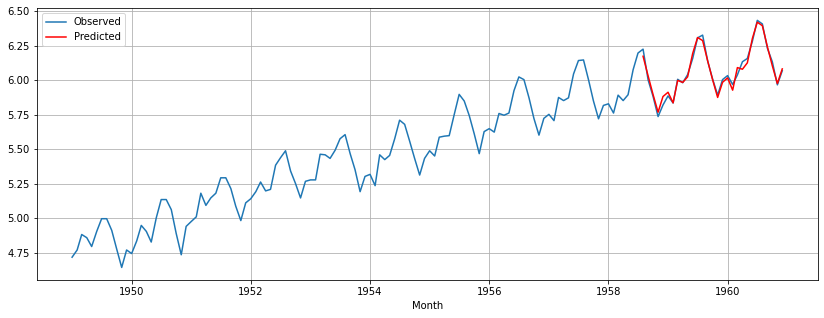

In [38]:
ts_plot_model(log_y, best_order, best_seasonal_order);

In [39]:
best_model = ARIMA(log_y, order=best_order, seasonal_order=best_seasonal_order)
results = best_model.fit()

C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


We can take a look at a summary of the model this library has built around our data.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        #CigSales   No. Observations:                  144
Model:             ARIMA(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                 248.481
Date:                          Sun, 14 Mar 2021   AIC                           -482.963
Time:                                  13:01:22   BIC                           -462.783
Sample:                              01-01-1949   HQIC                          -474.763
                                   - 12-01-1960                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9925      0.008    120.118      0.000       0.976       1.009
ma.L1         -0.4320      0.087     -4.957      0.000      -0.603      -0.261
ma.L2         -0.0291      0.086     -0.340      0.734      -0.197       0.139
ar.S.L12       0.9583      0.103      9.305      0.000       0.756       1.160
ma.S.L12      -1.9097      2.692     -0.709      0.478      -7.185       3.366
ma.S.L24       0.9825      2.740      0.359      0.720      -4.388       6.353
sigma2         0.0010      0.003      0.372      0.710      -0.004       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.91   Prob(JB):                         0.11
Heteroskedasticity (H):               0.65   Skew:                            -0.06
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [41]:
predictions = results.get_prediction()
predictions_mean = predictions.predicted_mean
predictions_se = predictions.se_mean
predictions_upper = predictions_mean + 2*predictions_se
predictions_lower = predictions_mean - 2*predictions_se

predictions_mean = predictions_mean['1950':]
predictions_upper = predictions_upper['1950':]
predictions_lower = predictions_lower['1950':]

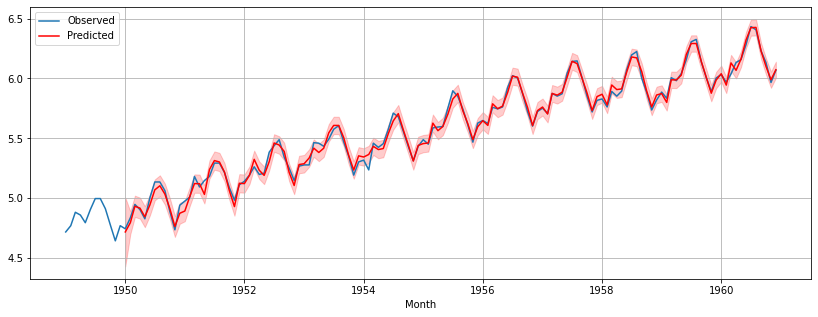

In [42]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.grid()
plt.plot(log_y, '-', label='Observed');
plt.plot(predictions_mean, '-r', label='Predicted')
plt.fill_between(x=predictions_mean.index, y1=predictions_lower, y2=predictions_upper, color='red', alpha=0.2)
plt.xlabel('Month');
plt.legend();

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

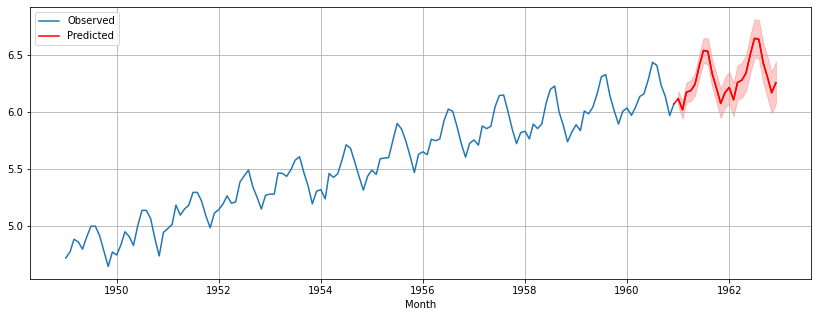

In [43]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
forecast = results.get_forecast(forecast_period)
forecast_mean = forecast.predicted_mean
forecast_se = forecast.se_mean
forecast_upper = forecast_mean + 2*forecast_se
forecast_lower = forecast_mean - 2*forecast_se

# Convert that range into a dataframe that includes your predictions
plot_log_y = log_y.append(forecast_mean)

# Plot your future predictions
fig, ax = plt.subplots(figsize=(14, 5))
ax.grid()
plt.plot(log_y, '-', label='Observed');
plt.plot(plot_log_y[-forecast_period-1:], '-r');
plt.plot(forecast_mean, '-r', label='Predicted')
plt.fill_between(x=forecast_mean.index, y1=forecast_lower, y2=forecast_upper, color='red', alpha=0.2)
plt.xlabel('Month');
plt.legend();

<span style="color:blue">It's important to note that this is the transformed series. We can invert the transformation to get predictions on the original time series.</span>

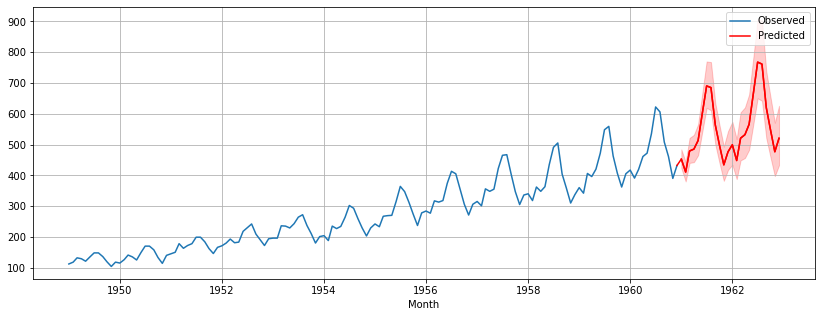

In [44]:
transformed_mean = np.exp(forecast_mean)
transformed_upper = np.exp(forecast_upper)
transformed_lower = np.exp(forecast_lower)

plot_y = y.append(transformed_mean)

fig, ax = plt.subplots(figsize=(14, 5))
ax.grid()
plt.plot(y, '-', label='Observed');
plt.plot(plot_y[-forecast_period-1:], '-r');
plt.plot(transformed_mean, '-r', label='Predicted')
plt.fill_between(x=transformed_mean.index, y1=transformed_lower, y2=transformed_upper, color='red', alpha=0.2)
plt.xlabel('Month');
plt.legend();

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 